## 1. Data

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
path2data = '/data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)

print(train_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
(5000, 3, 96, 96)


In [4]:
val_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(val_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [16]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

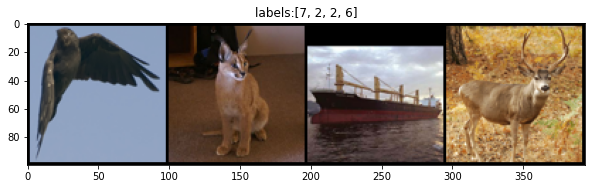

In [5]:
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(10)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

## 2. Model

![image](https://user-images.githubusercontent.com/44194558/152943141-8b9cde07-2c87-44c0-94b4-17cddc1cd20e.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/152943199-25f86d69-f8d0-45f0-811b-d4305f07cc67.png)

<br/>

**Standard Conv can be factorized into Depthwise Conv, Pointwise Conv**


**Depthwise Conv**

- `Separate layer for filtering`

- 각 입력 채널에 대한 필터 연산 

- Spatial Correlation

**Pointwise Conv**

- `Separate layer for combining (to create new features)`

- Depthwise conv의 출력 feature map들에 대한 1x1 conv (일종의 선형 결합 역할 수행)

- Cross-Channel Correlation


In [6]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # 참고 : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # groups=in_channels : Each input channel is convolved with its own set of filters
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

# Basic Conv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

![image](https://user-images.githubusercontent.com/44194558/152948293-5c30038c-34d0-464f-98ba-73dbb0e8b917.png)

각 conv layer 별로 색으로 구분

In [7]:
# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights = init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)

        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )

        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )

        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )

        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )

        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=10):
    return MobileNet(alpha, num_classes)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 224, 224)).to(device)
model = mobilenet(alpha=1).to(device)
output = model(x)
print('output size:', output.size())

output size: torch.Size([3, 10])


In [9]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
            ReLU6-10         [-1, 64, 112, 112]               0
        Depthwise-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            ReLU6-14           [-1, 64,

## 3. Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()

    return corrects

# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b

# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)  # pred

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)  # loss

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [11]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

In [17]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [18]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
Copied best model weights!
train loss: 1.996218, val loss: 1.767499, accuracy: 30.43, time: 0.1707 min
----------
Epoch 1/99, current lr= 0.01
Copied best model weights!
train loss: 1.687036, val loss: 1.633215, accuracy: 34.19, time: 0.3369 min
----------
Epoch 2/99, current lr= 0.01
train loss: 1.596427, val loss: 1.640072, accuracy: 36.25, time: 0.5022 min
----------
Epoch 3/99, current lr= 0.01


KeyboardInterrupt: ignored